In [10]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np

import torch.nn.functional as F
import torch.optim as optim
import tqdm



In [2]:
import os
 
path = 'EuroSAT_RGB'
dir_list = os.listdir(path)
convert_tensor = transforms.ToTensor()

images = []
labels = []


for label in dir_list:
    path = 'EuroSAT_RGB/'+ label + '/'
    dir_list = os.listdir(path)
    for file in dir_list:
        img = Image.open(path+file)
        convert_tensor(img)
        images.append( convert_tensor(img))
        labels.append(label)



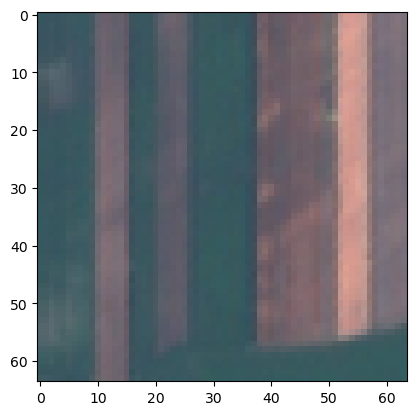

In [7]:

for i in range(10000,10001):
    plt.imshow(images[i].permute(1, 2, 0))
    plt.show()


In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)  # in_channels, out_channels, kernel_size, stride
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)  # Each channel gets zeroed out independently on each forward call with probability p
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
